#### Last Modified: July 24th, 2022 (Opal). 

## sOpInf applied to the Inviscid Burgers' Equation (Example #1) - Find the shift function c(t) via (1) the method of characteristics and (2) cross-correlation extrapolation.

In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/oissan/PycharmProjects/Space-Weather-ROM-Revised'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.optimize as optimize
import scipy
import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# Option 1: Method of Characteristics (MoC)

### Invisicid Burgers' Equation
The one-dimensional invisicid Burgers' equation is of the form:

\begin{equation} \label{inviscid-burgers-equation}
    \frac{\partial u(x, t)}{\partial t} + u(x, t)\frac{\partial u(x, t)}{\partial x} = 0
\end{equation}

The characteristic curves are defined as 
$$
\frac{\text{d} \tilde{x}}{\text{d} t} = u \qquad \text{and} \qquad \frac{\text{d}u(\tilde{x}, t)}{\text{d}t} = 0
$$

Shock forms when the characteristic lines first intersect - beyond this point, $(x_{s}, t_{s})$,  the solution develops a discontinuity and the wave "breaks". It is also the point where the conservation law, in its differential form, breaks down. In order to avoid a multi-valued solution, the triple-valued region is replaced with a discontinuity. 


### Set Rectangular Computational Grid Size

In [4]:
# number of mesh points in the T (time) axis. 
m = 1000
# number of mesh points in X (spatial) axis. 
n = 10000
# final time. 
T = 2
# boundary of x [a, b].
a = 0
b = 3

In [5]:
# time and spatial grid (uniform spacing).
t_vec = np.linspace(0, T, m)
x_vec = np.linspace(a, b, n)

### Set Initial Condition

In [6]:
# gaussian initial condition
initial_condition = 0.8 +  0.5*np.exp(-(x_vec - 1)**2/(0.1))

The initial condition is of the form 

$$
u_{0}(x) = 0.8 + 0.5\exp(-10(x-1)^2)
$$

The nonlinear steepening produces the shock at $(x_{s}, t_{s}, \tilde{x}_{s})$ and these three unknowns are determined from solving the coupled system of equations:
$$
u_{0}''(\tilde{x}_{s}) = 0,\\
1 + t_{s} u_{0}'(\tilde{x}_{s}) = 0,\\
x_{s} = \tilde{x}_{s} + t_{s} u_{0}(\tilde{x}_{s}).
$$

Since $u_{0}'(\tilde{x}_{s}) = -10(x-1)\exp(-10(x-1)^2)$
and $u_{0}''(\tilde{x}_{s}) = (200x^2 - 400x + 190) \exp(-10(x-1)^2) = 0$, 
the characteritsic where shock emerges begins at $\tilde{x}_{s} = \frac{10 \pm \sqrt{5}}{10}$. The second equation yields the time where the shock emerges ,$t_s$, i.e.
$$
t_{s} =\frac{-1}{u_{0}'(\tilde{x}_{s})} = \frac{-1}{-10(\tilde{x}_{s}-1)\exp(-10(\tilde{x}_{s}-1)^2)} = \pm \frac{1}{\sqrt{5} \exp \left(-\frac{1}{2}\right)},
$$
and since $t_{s} > 0$, we get $t_{s} \approx 0.737$. Lastly, the shock spatial location is at
$$
x_{s} = \frac{10 + \sqrt{5}}{10} + \frac{1}{\sqrt{5} \exp \left(-\frac{1}{2}\right)} u_{0} \left(\frac{10 + \sqrt{5}}{10}\right) \approx 2.037
$$

In [7]:
def u_0(x):
    """ Initial condition (gaussian)"""
    return 0.8 + 0.5*np.exp(-10*((x-1)**2))

def u_tag(x):
    """ the first derivative (of u0)"""
    return -10*(x-1)*np.exp(-10*((x-1)**2))

def u_tag_tag(x):
    """ the second derivative (of u0)"""
    return (200*(x**2) - 400*x + 190)*np.exp(-10*((x-1)**2))

In [8]:
x_s_tilde = (10 + np.sqrt(5))/10
print("x_s_tilde (+)= ", (10 + np.sqrt(5))/10)
print("x_s_tilde (-)= ", (10 - np.sqrt(5))/10)

x_s_tilde (+)=  1.223606797749979
x_s_tilde (-)=  0.7763932022500211


In [9]:
t_s = -1/u_tag(x_s_tilde)
print("t_s = " + str(t_s))

t_s = 0.7373305674470638


In [10]:
x_s = x_s_tilde + t_s * u_0(x_s_tilde)
print("x_s = ", + x_s)

x_s =  2.037078049457609


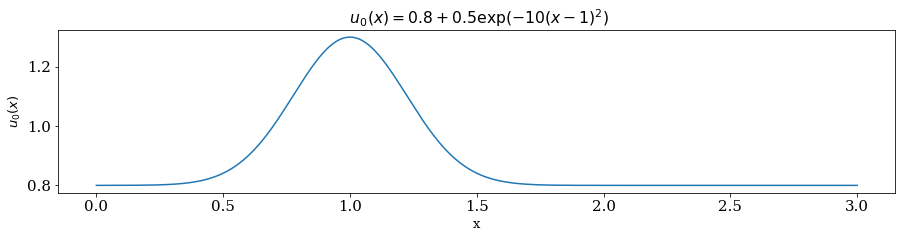

In [11]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(x_vec, initial_condition)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("$u_{0}(x)$")
_ = ax.set_title(" $u_{0}(x) = 0.8 + 0.5\exp(-10(x-1)^2)$" )

In [12]:
index = []
shock_index = np.argmin(np.abs(t_vec - t_s))
for ii in np.arange(0, len(x_vec)):
    x_ii = (x_vec[ii] + initial_condition[ii]*t_vec[shock_index])
    min_val = np.min(np.abs(x_ii - x_s))
    if min_val < 6e-2:#5.5e-4:
        index.append(ii)

In [13]:
index1 = np.min(index)
index2 = np.max(index)

In [14]:
print(x_vec[index1])
print(x_vec[index2])

1.0210021002100211
1.4653465346534655


In [15]:
np.mean(initial_condition[index1:index2])

1.0801002695714976

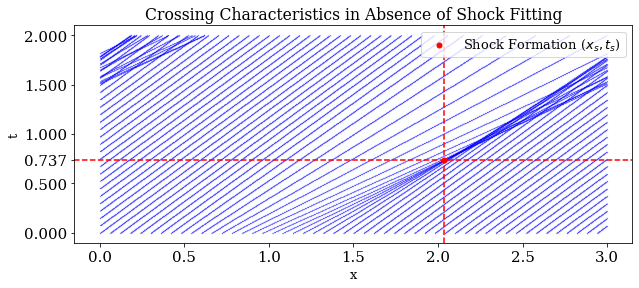

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
for ii in np.arange(0, len(x_vec), 200):
    ax.scatter((x_vec[ii] + initial_condition[ii]*t_vec) % b,t_vec, color="b", s=0.05, alpha=0.5)

#ax.scatter((x_vec[index1] + initial_condition[index1]*t_vec) % b,t_vec, color="k", s=0.05)
#ax.scatter((x_vec[index2] + initial_condition[index2]*t_vec) % b,t_vec, color="k", s=0.05)
#_ = ax.set_xlim(1, 2.2)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("t")
_ = ax.set_title("Crossing Characteristics in Absence of Shock Fitting")
_ = ax.scatter(x_s, t_s, s = 25, color="r", label=r"Shock Formation ($x_{s}, t_{s}$)")
_ = ax.axvline(x_s, ls="--", c="r")
_ = ax.axhline(t_s, ls="--", c="r")
#_ = ax.set_xticks([0, 1,  round(x_s, 3), 3])
_ = ax.set_yticks([0, 0.5, round(t_s, 3), 1, 1.5, 2])
_ = ax.legend()

# Shock Fitting - Whitham's Equal Area Rule
To determine the shock path we must solve the following system (the Rankine-Hugoniot jump condition):

$$
s(t) = \tilde{x}_{+}+ t u_{0}(\tilde{x_{+}}, 0)\\
s(t) = \tilde{x}_{-}+ t u_{0}(\tilde{x_{-}}, 0)\\
\dot{s}(t) = \frac{1}{2} \left[ u_{0}(\tilde{x}_{-})  + u_{0}(\tilde{x}_{+})\right]
$$
where $\tilde{x}_{+}$ is the characteristic right after the shock and $\tilde{x}_{+}$ is the characteristic right before the shock. Since $\tilde{x}_{+}$ and $\tilde{x}_{-}$ change with time, computing $s(t)$ is non-trivial in many cases. 

Fortunately, instead, we can use the *Whitham's (1974) equal-area rule*: on the multi-valued solution at time $t$ the shock $s(t)$ is located by drawing a vertical line which cuts off equal area lobes. If we replace part of the multivalued solution interval with a shock, some mass will be removed (area  $A_{1}$  in the figure below) and some mass will be added (area  $A_{2}$  in the figure below). Number conservation means that when we replace the multivalued solution by the discontinuous one, the area under the curve must remain the same, thus, $A_{1} = A_{2}$.
Extensively, this Whitham equal-area rule argues that both the multivalued solution and the discontinuious solution satisfy the conservation law. Thus, for any breaking wave at $s(t)$, the area under each curve must be equal.

In [17]:
def area_compute(index1, index2, x_shifted, u, s,  method="trap"):
    """ function to compute area between a vertical line x=s(t) and the multivalued function u(x, t)"""
    if method=="trap":
        return np.trapz(x_shifted[index1:index2] - s, x=u[index1:index2])
    if method=="simps":
        return scipy.integrate.simpson(x_shifted[index1:index2], x=u[index1:index2])
    else:
        return None



def get_index(diff):
    """ get indexes where x=s(t) and the multivalued function u(x, t) intercept"""
    asign = np.sign(diff)
    signchange = (np.diff(asign) != 0)*1
    return np.where(signchange==1)[0]

In [18]:
def get_s_opt(t_idx, x_vec, t_vec, a, b, initial_condition, n_search=int(1e5)):
    """ function to get the optimal s (shock) based on Whitham (1974) geometrical arguments """
    # shifted coordinates
    x_shifted = (x_vec + initial_condition*t_vec[t_idx]) 

    # shock location initial guess
    s_vec = np.linspace(a, b*2, n_search)
    area_diff = np.zeros(n_search)

    for s_idx, s in enumerate(s_vec):
        # difference between shifted location and current shock s
        diff = x_shifted - s
        # figure out where the two curves intersect
        index = get_index(diff)

        if len(index) != 3: 
            area_diff[s_idx] = np.inf

        else:
            # compute the area between the two curves
            area1 = np.abs(area_compute(index1=index[0], index2=index[1], x_shifted=x_shifted, u=initial_condition, s=s))
            area2 = np.abs(area_compute(index1=index[1], index2=index[2], x_shifted=x_shifted, u=initial_condition, s=s))
            area_diff[s_idx] = np.abs(area1 - area2)
            
    if t_idx % 50 == 0 and len(get_index(x_shifted- s_vec[np.argmin(area_diff)])) == 3:       
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.scatter(x_shifted%b, initial_condition, s=0.1)
        ax.scatter(s_vec[np.argmin(area_diff)]%b, initial_condition[get_index(x_shifted- s_vec[np.argmin(area_diff)])[0]], c="r")
        ax.scatter(s_vec[np.argmin(area_diff)]%b, initial_condition[get_index(x_shifted- s_vec[np.argmin(area_diff)])[1]], c="r")
        ax.scatter(s_vec[np.argmin(area_diff)]%b, initial_condition[get_index(x_shifted- s_vec[np.argmin(area_diff)])[2]], c="r")
        ax.axvline(s_vec[np.argmin(area_diff)]%b, c="k", label="approximate = " + str(round(s_vec[np.argmin(area_diff)], 3)))
        ax.set_xlabel("x")
        ax.set_ylabel("u(x,t)")
        ax.set_title(r"t = " + str(round(t_vec[t_idx], 3))+"\n $|A_{1} - A_{2}|$ = " + str(np.min(area_diff)))

        plt.legend()
        plt.show()

    return s_vec[np.argmin(area_diff)] 

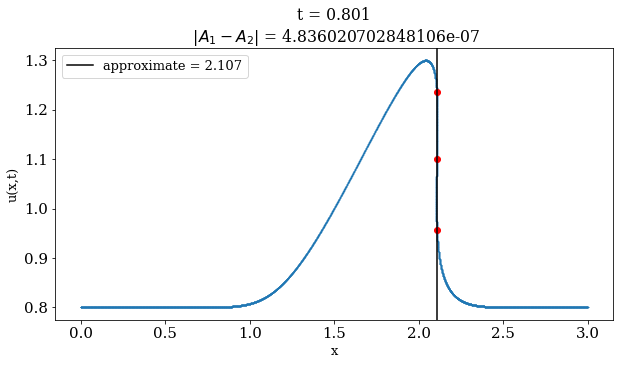

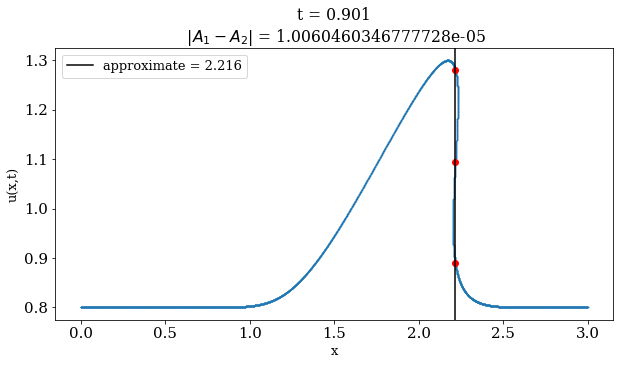

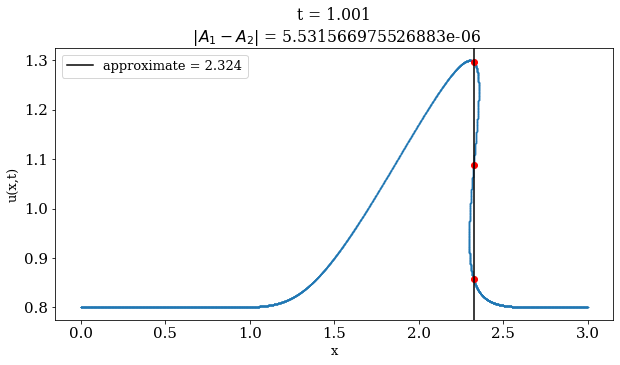

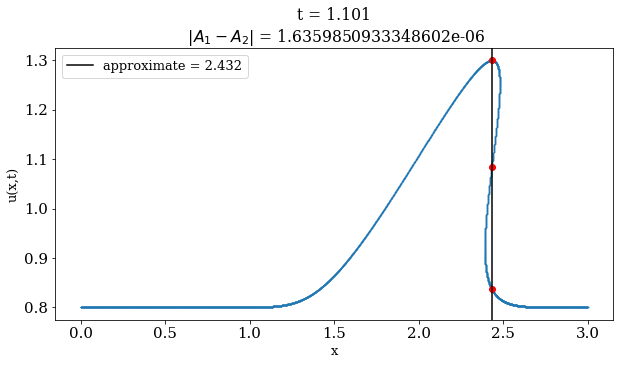

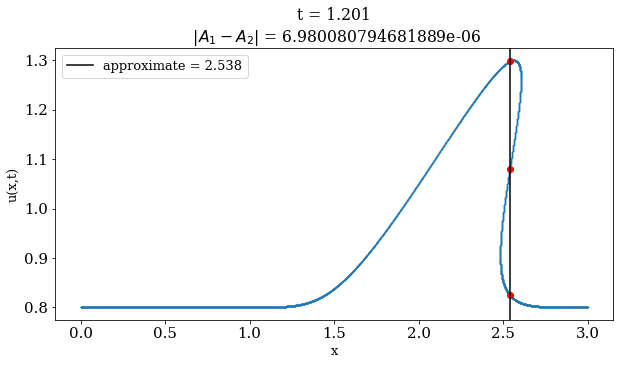

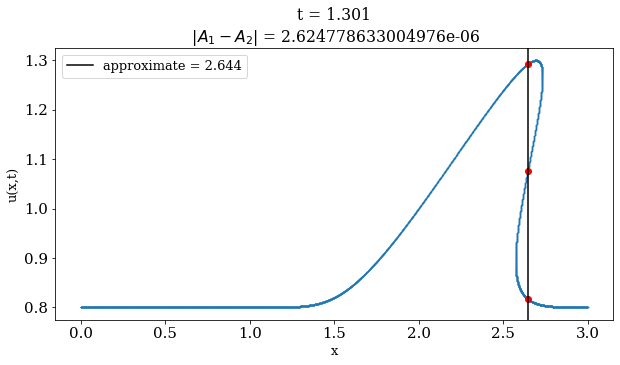

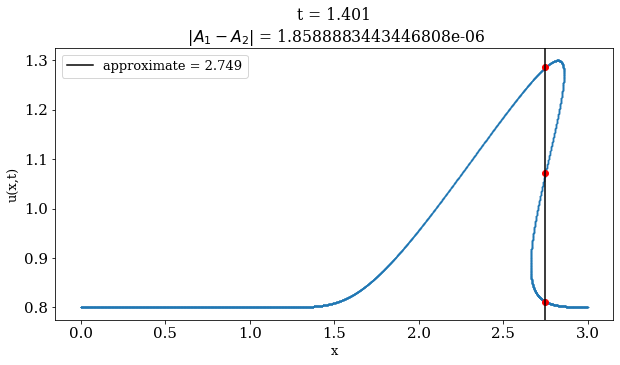

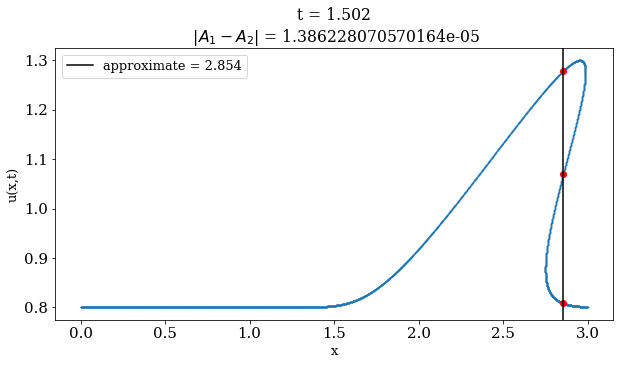

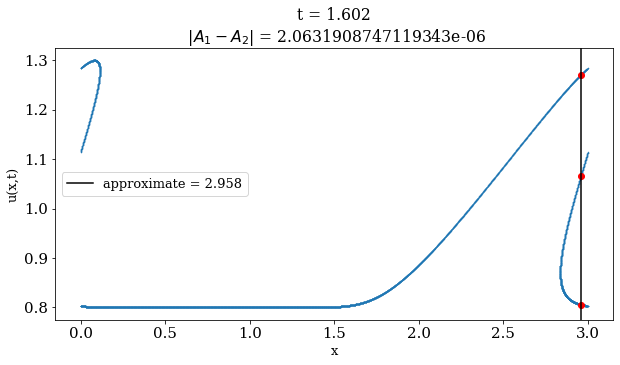

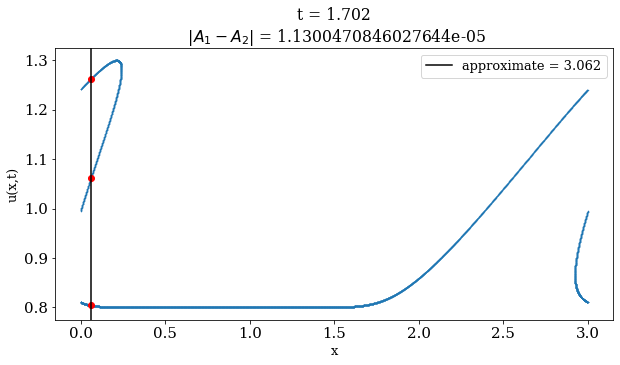

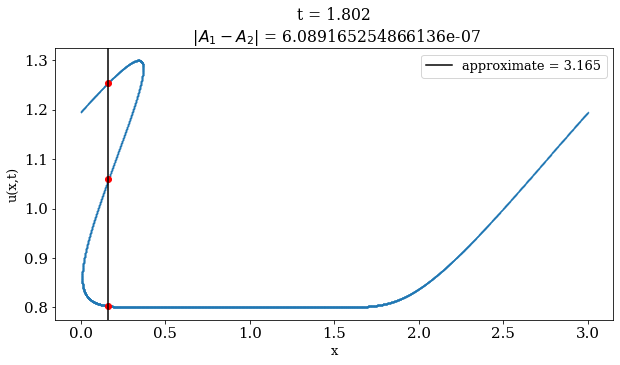

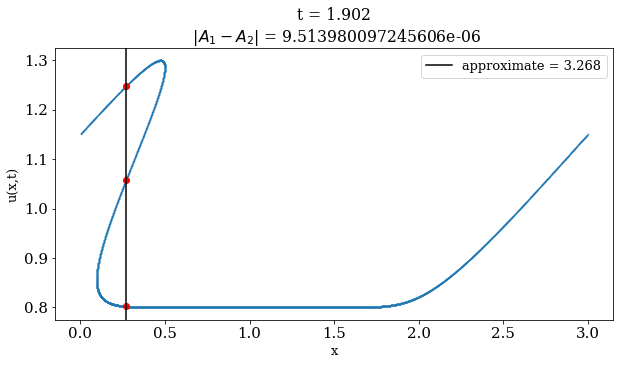

In [19]:
s_curve = np.ones(len(t_vec)) * np.inf
for t_idx, tt in enumerate(t_vec):
    if tt > t_s + 1e-2:
        # s(t) -- compute for each t slice
        s_curve[t_idx] = get_s_opt(t_idx, x_vec, t_vec, a, b, initial_condition)

In [20]:
for ii in range(len(s_curve)):
    if s_curve[ii] != np.inf:
        n_start = ii 
        break

In [21]:
def func_asymp(t, a,b,c, d):
    return a*t + b*np.sqrt(t + c) +d 

popt = scipy.optimize.curve_fit(func_asymp, t_vec[n_start:], s_curve[n_start:])[0]

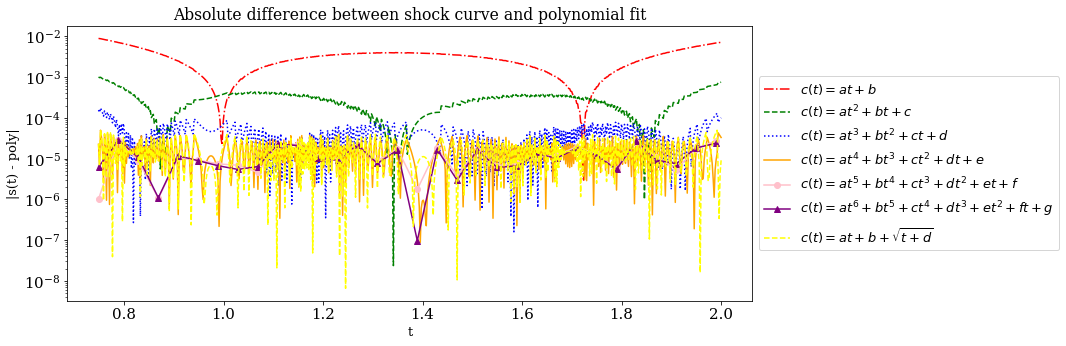

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

# _ = ax[0].plot(t_vec[n_start:], s_curve[n_start:], label="shock curve")

linear_par = np.polyfit(t_vec[n_start:], s_curve[n_start:], 1)
# _ = ax[0].plot(t_vec[n_start:], np.polyval(linear_par, t_vec[n_start:]), c="r", ls="-.", label="linear-fit")

quad_par = np.polyfit(t_vec[n_start:], s_curve[n_start:], 2)
# _ = ax[0].plot(t_vec[n_start:], np.polyval(quad_par, t_vec[n_start:]),
#                c="g", ls="--", label="quadratic-fit")

cubic_par = np.polyfit(t_vec[n_start:], s_curve[n_start:], 3)
# _ = ax[0].plot(t_vec[n_start:], np.polyval(cubic_par, t_vec[n_start:]), c="b", ls=":", label="cubic-fit")

quat_par = np.polyfit(t_vec[n_start:], s_curve[n_start:], 4)
# _ = ax[0].plot(t_vec[n_start:], np.polyval(quat_par, t_vec[n_start:]), c="orange", ls="-", label="quartic-fit")

fifth_par = np.polyfit(t_vec[n_start:], s_curve[n_start:], 5)
# _ = ax[0].plot(t_vec[n_start:][::20], np.polyval(fifth_par, t_vec[n_start:][::20]),'-o',  c="pink", linewidth=0.5, label="quintic-fit")

sixth_par = np.polyfit(t_vec[n_start:], s_curve[n_start:], 6)

_ = ax.plot(t_vec[n_start:], np.abs(s_curve[n_start:] - np.polyval(linear_par, t_vec[n_start:])), c="r",  ls="-.",  label=r"$c(t) = a t + b$")
_ = ax.plot(t_vec[n_start:], np.abs(s_curve[n_start:] - np.polyval(quad_par, t_vec[n_start:])), c="g", ls="--", label=r"$c(t) = a t^2 + b t + c$")
_ = ax.plot(t_vec[n_start:], np.abs(s_curve[n_start:] - np.polyval(cubic_par, t_vec[n_start:])), c="b", ls=":", label=r"$c(t) = a t^3 + b t^2 + ct + d$")
_ = ax.plot(t_vec[n_start:], np.abs(s_curve[n_start:] - np.polyval(quat_par, t_vec[n_start:])), c="orange", ls="-", label=r"$c(t) = at^4 + bt^3 + ct^2+ dt + e$")
_ = ax.plot(t_vec[n_start:][::20], np.abs(s_curve[n_start:] - np.polyval(fifth_par, t_vec[n_start:]))[::20], '-o',  c="pink", label="$c(t) = at^5 + bt^4 + ct^3 + dt^2+ et + f$")
_ = ax.plot(t_vec[n_start:][::20], np.abs(s_curve[n_start:] - np.polyval(sixth_par, t_vec[n_start:]))[::20], '-^',  c="purple", label="$c(t) = at^6 + bt^5 + ct^4 + dt^3+ et^2 + ft + g$")
_ = ax.plot(t_vec[n_start:], np.abs(s_curve[n_start:] - func_asymp(t_vec[n_start:], *popt)), '--',  c="yellow", label=r"$c(t) = at + b + \sqrt{t + d}$")


_ = ax.legend()
_ = ax.set_yscale("log")
_ = ax.set_xlabel("t")
_ = ax.set_ylabel("|s(t) - poly|")
_ = ax.set_title("Absolute difference between shock curve and polynomial fit")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("Burgers/figs/shock_curve_approx_poly.png", dpi=600)
# print("m = ", m_linear)
# print("n = ", n_linear)

# Collection of characteristic curves

In [23]:
# initialize set of characteristic curves
char_curves = np.zeros((len(x_vec), len(t_vec)))

# loop over each point
for ii in np.arange(len(x_vec)):
    for jj in np.arange(len(t_vec)):
        x_loc = (x_vec[ii] + initial_condition[ii]*t_vec[jj])
        if np.min(np.abs(s_curve[jj]%b - x_loc%b)) < 1e-3:
            char_curves[ii, jj:] = s_curve[jj:]*np.nan
            break
        else:
            char_curves[ii, jj] = x_loc 

In [24]:
index1=np.argmin(np.abs(x_vec - 1.15)) # 200 (0.6)
print(x_vec[index1])
index2=np.argmin(np.abs(x_vec - 1.4))# 600 (1.8)
print(x_vec[index2])
print(np.mean(initial_condition[index1:index2]))

1.15001500150015
1.3999399939994
1.0404870507787198


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62214/3902795196.py:17: RuntimeWarning: invalid value encountered in remainder
  x_curve_index = np.nanargmin(np.abs(char_curves[ii, :]%b - b))
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62214/3902795196.py:19: RuntimeWarning: invalid value encountered in remainder
  ax.plot(char_curves[ii, x_curve_index+1:]%b, t_vec[x_curve_index+1:], alpha=0.5, color="b")
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62214/3902795196.py:17: RuntimeWarning: invalid value encountered in remainder
  x_curve_index = np.nanargmin(np.abs(char_curves[ii, :]%b - b))
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62214/3902795196.py:19: RuntimeWarning: invalid value encountered in remainder
  ax.plot(char_curves[ii, x_curve_index+1:]%b, t_vec[x_curve_index+1:], alpha=0.5, color="b")
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62214/3902795196.py:17: RuntimeWarning: invalid value encountered in re

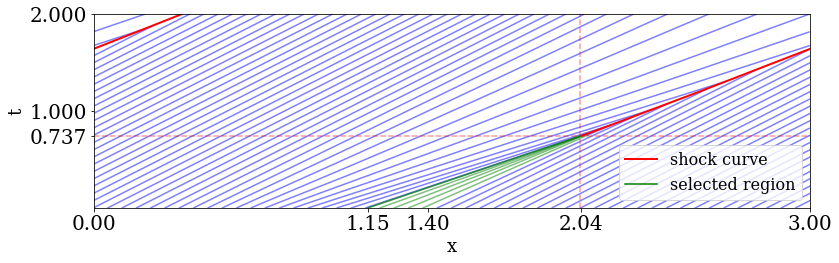

In [35]:
font = {'family' : 'serif',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(figsize=(12, 4))
#_ = ax.scatter(x_s, t_s, s = 100, color="k", alpha=1, label=r"shock formation $(x_{s}, t_{s})$")
for ii in np.arange(0, len(x_vec), 200):
    if index1 < ii < index2 :
        ax.plot(char_curves[ii, :n_start]%b, t_vec[:n_start], alpha=0.5, color="g")
        x_curve_index = np.argmin(np.abs(char_curves[ii, :] - b))
        ax.plot(char_curves[ii, n_start:x_curve_index]%b, t_vec[n_start:x_curve_index], alpha=0.5, color="b")
        ax.plot(char_curves[ii, x_curve_index:]%b, t_vec[x_curve_index:], alpha=0.5, color="b")
    else:
        x_curve_index = np.nanargmin(np.abs(char_curves[ii, :]%b - b))
        ax.plot(char_curves[ii, :x_curve_index]%b, t_vec[:x_curve_index], alpha=0.5, color="b")
        ax.plot(char_curves[ii, x_curve_index+1:]%b, t_vec[x_curve_index+1:], alpha=0.5, color="b")  

ax.plot(char_curves[index1, :n_start]%b, t_vec[:n_start], alpha=0.5, color="g")
ax.plot(char_curves[index1, :n_start]%b, t_vec[:n_start], alpha=0.5, color="g")
s_curve_index = np.argmin(np.abs(s_curve - b))
ax.plot(s_curve[:s_curve_index]%b,t_vec[:s_curve_index], c="red", linewidth=2)
ax.plot(s_curve[s_curve_index+1:]%b,t_vec[s_curve_index+1:], c="red", linewidth=2, label="shock curve")
ax.plot(s_curve[s_curve_index:]%b * np.nan,t_vec[s_curve_index:]*np.nan, c="g", label="selected region")

_ = ax.set_xlim(a, b)
_ = ax.set_ylim(0, T)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("t")
#_ = ax.set_title("Characteristic Curves")

_ = ax.axvline(x_s, ls="--", c="r", alpha=0.4)
_ = ax.axhline(t_s, ls="--", c="r", alpha=0.4)
_ = ax.set_xticks([0, round(x_vec[index1], 2), round(x_vec[index2], 2), round(x_s, 2), 3])
_ = ax.set_yticks([round(t_s, 3), 1,  2])

_ = ax.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.savefig("Burgers/figs/characteristic_lines_shock_formation.png")

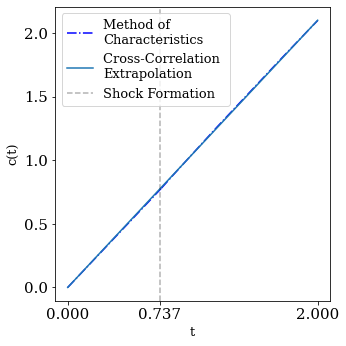

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(t_vec[: n_start], np.mean(initial_condition[index1:index2])* t_vec[:n_start] , c="b", ls="-.", label="Method of \nCharacteristics")
plt.plot(t_vec[n_start:], s_curve[n_start:] -s_curve[n_start] + np.mean(initial_condition[index1:index2])* t_vec[n_start], c="b", ls="-.")
ax.plot(t_vec, t_vec*1.05, label="Cross-Correlation \nExtrapolation")
ax.axvline(t_s, c="k", ls="--", alpha=0.3, label="Shock Formation")
ax.set_xticks([0, 2, round(t_s, 3)])
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("c(t)")
#ax.set_title(r"Shift function $c(t)$")
plt.tight_layout()
plt.savefig("Burgers/figs/shift_function_comparison.png")

In [27]:
moc = np.zeros(len(t_vec))
moc[:n_start] = np.mean(initial_condition[index1:index2])* t_vec[:n_start]
moc[n_start:] = s_curve[n_start:] - s_curve[n_start] + np.mean(initial_condition[index1:index2])* t_vec[n_start]

In [28]:
np.savetxt('Burgers/shock_curve.csv', moc, delimiter=',')